In [ ]:
import os
import cv2
import time
from copy import deepcopy
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from pathlib import Path
from statistics import mode

In [ ]:
BASE_DIR = Path('/Users/dev/Neural Network/Дипломный проект «Data Scientist. ML. Средний уровень (нейронные сети)»')
os.chdir(BASE_DIR)

#train.csv (download from Kaggle)
df = pd.read_csv(BASE_DIR  / 'train.csv', sep=',', index_col=0)
# Словарь эмоций
emotion_mapping = dict(enumerate(df['emotion'].unique()))

In [ ]:
class emotion_model:
    def __init__(self, config:str):
        self.config = config
        self.model = tf.keras.models.load_model(self.config)
        # warm-up model on a random sample
        self.img_size = 224
        sample = tf.random.uniform((1, self.img_size, self.img_size, 3), 0, 1)
        self.model(sample)
        
    def predict_model(self, image):
        image = np.expand_dims(image, axis=0)
        image = utils.preprocess_input(image, version=2)
        predicts = self.model.predict(image)
        emotion = emotion_mapping[np.argmax(predicts)]
        return emotion

In [ ]:
model_emotion = emotion_model(BASE_DIR / 'model_emotion/checkpoint_best_vgg')

# Инференс с каскадом Хаара

In [ ]:
emotion_mean_list = []
emotion_mean = 'uncertain'
prev_frame_time = 0
new_frame_time = 0

cam = cv2.VideoCapture(0)
#!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
# иницилизируем детектор:
face_detector = cv2.CascadeClassifier(str(BASE_DIR) +'/haarcascade_frontalface_default.xml')
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 480) # ширина кадра -- 640 пикселей
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # высота кадра -- 480 пикселей

while(True):
    ret, bgr_frame = cam.read()    
    rgb_frame = bgr_frame[:, :, ::-1]
    grayscale_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector.detectMultiScale(grayscale_image, scaleFactor=1.3, minNeighbors=5, minSize=(10, 10))

    try:
        face = faces[0]
    except:
        pass
    x, y, h, w = face

    new_frame_time = time.time()
    fps = round(1/(new_frame_time - prev_frame_time))
    prev_frame_time = new_frame_time

    face_boundingbox_bgr = bgr_frame[x:x + h, y:y + w]
    face_boundingbox_rgb = cv2.cvtColor(face_boundingbox_bgr, cv2.COLOR_BGR2RGB)
    
    # VGGFace. В предикт подаем содержимое bounding-box, а не целый frame!  
    img = image.img_to_array(cv2.resize(face_boundingbox_rgb, dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
    emotion = model_emotion.predict_model(img)
    
    # буфер, усредняющий инференс выводимой эмоции по 5-ти кадрам
    emotion_mean_list.append(emotion)
    if len(emotion_mean_list) > 5:
        emotion_mean = mode(emotion_mean_list)
        emotion_mean_list = []

    rgb_image_with_boundingbox = deepcopy(bgr_frame)
    rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (x, y), (x + h, y + w), (0,255,0), 3)
    rgb_image_with_boundingbox_and_text = deepcopy(rgb_image_with_boundingbox)
    rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox_and_text, emotion_mean + str(', FPS = ') + str(fps), (x + 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow("facial emotion recognition", rgb_image_with_boundingbox_and_text)
   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

del cam # release camera
cv2.destroyAllWindows()

# Инференс с детектором CV-DNN

In [ ]:
modelFile = str(BASE_DIR) + str('/res10_300x300_ssd_iter_140000.caffemodel')
configFile = str(BASE_DIR) + str('/deploy.prototxt')
detector = cv2.dnn.readNetFromCaffe(configFile, modelFile)

def get_boxes(image):
    height, width = image.shape[:2]
    conf_threshold = .5
    
    blob = cv2.dnn.blobFromImage(
        image=image, 
        scalefactor=1.0,
        size=(300, 300), 
        mean=(104.0, 177.0, 123.0),
        swapRB=True,
    )
    
    detector.setInput(blob)
    detections = detector.forward()
    
    boxes = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * width)
            y1 = int(detections[0, 0, i, 4] * height)
            x2 = int(detections[0, 0, i, 5] * width)
            y2 = int(detections[0, 0, i, 6] * height)
            boxes.append((x1, y1, x2, y2))
    return boxes

emotion_mean_list = []
emotion_mean = 'uncertain'
prev_frame_time = 0
new_frame_time = 0

cam = cv2.VideoCapture(0)
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 480) # ширина кадра -- 640 пикселей
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480) # высота кадра -- 480 пикселей


while(True):
    ret, bgr_frame = cam.read()    
    rgb_frame = bgr_frame[:, :, ::-1]
    grayscale_image = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2GRAY)
    
    try:
        boxes = get_boxes(rgb_frame)
        x, y, h, w = boxes[0]
    except:
        pass    
    
    new_frame_time = time.time()
    fps = round(1/(new_frame_time - prev_frame_time))
    prev_frame_time = new_frame_time
    
    face_boundingbox_bgr = bgr_frame[x:h, y:w]
    face_boundingbox_rgb = cv2.cvtColor(face_boundingbox_bgr, cv2.COLOR_BGR2RGB)
    
    # VGGFace. В предикт подаем содержимое bounding-box, а не целый frame!
    img = image.img_to_array(cv2.resize(face_boundingbox_rgb, dsize=(224, 224), interpolation=cv2.INTER_CUBIC))
    emotion = model_emotion.predict_model(img)
    
    # буфер, усредняющий инференс выводимой эмоции по 5-ти кадрам
    emotion_mean_list.append(emotion)
    if len(emotion_mean_list) > 5:
        emotion_mean = mode(emotion_mean_list)
        emotion_mean_list = []

    rgb_image_with_boundingbox = deepcopy(bgr_frame)
    rgb_image_with_boundingbox = cv2.rectangle(rgb_image_with_boundingbox, (x, y), (h, w), (0,255,0), 3)
    rgb_image_with_boundingbox_and_text = deepcopy(rgb_image_with_boundingbox)
    rgb_image_with_boundingbox_and_text = cv2.putText(rgb_image_with_boundingbox_and_text, emotion_mean + str(', FPS = ') + str(fps), (x + 20, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow("facial emotion recognition", rgb_image_with_boundingbox_and_text)
   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

del cam # release camera
cv2.destroyAllWindows()

# Скриншоты видео-потока в режиме реал-тайм

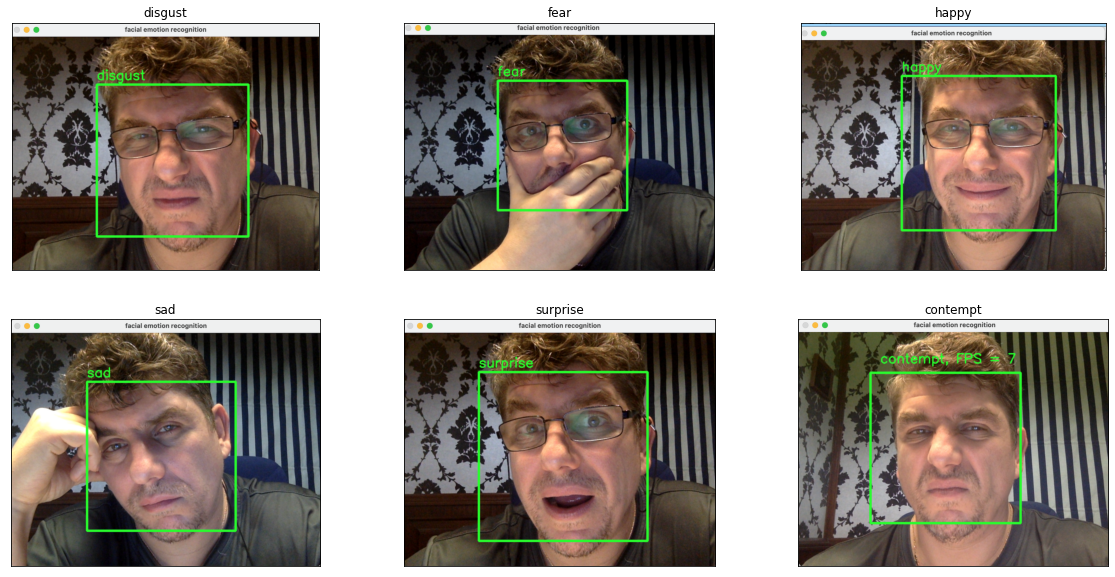

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(20,10))
emotion = ['disgust', 'fear', 'happy', 'sad', 'surprise','contempt']
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(emotion[i])
    plt.grid(False)
    image_path = str(BASE_DIR) + str('/real_time_predict/') + str(i+1) + str('.png')
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap=plt.cm.gray)

# Выводы.
Подавая в предикт модели обрезанные по bounding-box-ам фреймы видео-потока разными детекторами лица (каскад Хаара, CV-DNN) мы получаем разную точность детектирования эмоции, т.к. ранее нами были установлено, что качество распознавания эмоций лучше на необрезанных фотографиях. При этом, bounding-box-ы какскада Хаара менее точны в детектировании лица и захватывают бОльшую часть изображения (лицо + некоторое пространство вокруг головы).  В то время как детектор CV-DNN более строг в обрезке. Из чего следует, что в нашем конкретном случае менее строгое детектирование каскадами Хаара будет более предпочтительным для повышения точности определения эмоций. В качестве бонуса каскад Хаара обеспечивает более высокий FPS.

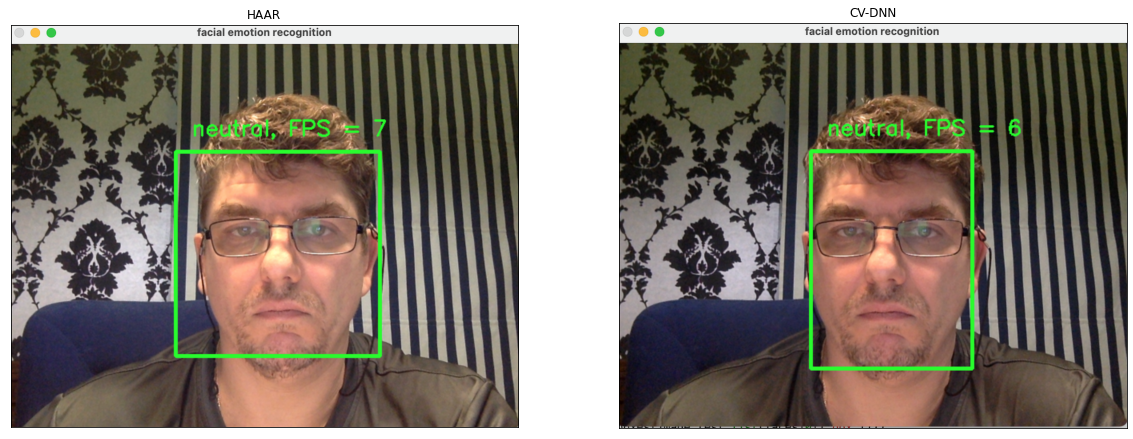

In [ ]:
plt.figure(figsize=(20,10))
detector = ['HAAR', 'CV-DNN']
for i in range(7,9):
    plt.subplot(1,2, i-6)
    plt.xticks([])
    plt.yticks([])
    plt.title(detector[i-7])
    plt.grid(False)
    image_path = str(BASE_DIR) + str('/real_time_predict/') + str(i) + str('.png')
    img = mpimg.imread(image_path)
    plt.imshow(img, cmap=plt.cm.gray)